# Bias Mitigation in AI Models for Cardiovascular Diseases Prediction

### Giorgia Castelli, Alice Fratini, Madalina Ionela Mone

We aim to detect and mitigate bias in a Cardiovascular Diseases Prediction pipeline.

We will first implement a simple predictive model for the binary classification of patients; we will then detect possible biases in the pipeline and implement different techniques for bias mitigation; finally, we will comment the results.

Among the metrics and bias mitigation techniques used, some belong to the  [Aequitas-Fairlib](https://pypi.org/project/aequitas-fairlib/) library.

## Imports

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from fairlib import DataFrame
from fairlib.inprocessing import AdversarialDebiasing
from fairlib.metrics import statistical_parity_difference, disparate_impact, equality_of_opportunity
from fairlearn.metrics import equalized_odds_ratio
from itertools import product

from IPython.display import display

We are using the Heart Attack Prediction Dataset, available at https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset/data

## Data Loading

In [3]:
# Read the CSV file
file_path = r"heart_attack_prediction_dataset.csv"
df = pd.read_csv(file_path)

print("Length of the dataset:", len(df))
print("\n")
display(df.head())

Length of the dataset: 8763




,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0


In [4]:
# The useless ID column is dropped
df = df.drop(['Patient ID'], axis=1)

## Data Exploration

In [5]:
# Summary Statistics
print("Summary Statistics:")
display(df.describe())
print("\n")

# Missing Values
print("\nMissing Values:")
display(df.isnull().sum())

Summary Statistics:


,Age,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,53.707977,259.877211,75.021682,0.652288,0.492982,0.896839,0.501426,0.598083,10.014284,0.495835,0.498345,5.469702,5.993690,158263.181901,28.891446,417.677051,3.489672,7.023508,0.358211
std,21.249509,80.863276,20.550948,0.476271,0.499979,0.304186,0.500026,0.490313,5.783745,0.500011,0.500026,2.859622,3.466359,80575.190806,6.319181,223.748137,2.282687,1.988473,0.479502
min,18.000000,120.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002442,0.000000,0.000000,1.000000,0.001263,20062.000000,18.002337,30.000000,0.000000,4.000000,0.000000
25%,35.000000,192.000000,57.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.981579,0.000000,0.000000,3.000000,2.998794,88310.000000,23.422985,225.500000,2.000000,5.000000,0.000000
50%,54.000000,259.000000,75.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.069559,0.000000,0.000000,5.000000,5.933622,157866.000000,28.768999,417.000000,3.000000,7.000000,0.000000
75%,72.000000,330.000000,93.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.050018,1.000000,1.000000,8.000000,9.019124,227749.000000,34.324594,612.000000,5.000000,9.000000,1.000000
max,90.000000,400.000000,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.998709,1.000000,1.000000,10.000000,11.999313,299954.000000,39.997211,800.000000,7.000000,10.000000,1.000000





Missing Values:


Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64

We then split the Blood Pressure column into a Maximum and a Minimum column, for a more clean visualization and usage

In [6]:
# Split the 'Blood Pressure' column into 'Blood Pressure Maximum' and 'Blood Pressure Minimum'
df[['Blood Pressure Maximum', 'Blood Pressure Minimum']] = df['Blood Pressure'].str.split('/', expand=True)

df['Blood Pressure Maximum'] = pd.to_numeric(df['Blood Pressure Maximum'], downcast='integer')
df['Blood Pressure Minimum'] = pd.to_numeric(df['Blood Pressure Minimum'], downcast='integer')

df = df.drop(columns=['Blood Pressure'])

columns = [col for col in df.columns if col != 'Heart Attack Risk'] + ['Heart Attack Risk']
df = df[columns]

In [7]:
df.columns

Index(['Age', 'Sex', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country',
       'Continent', 'Hemisphere', 'Blood Pressure Maximum',
       'Blood Pressure Minimum', 'Heart Attack Risk'],
      dtype='object')

The distributions of potentially bias-inducing columns are visualized.

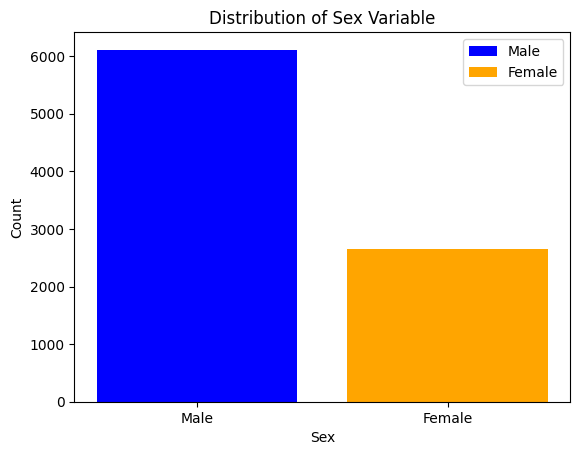

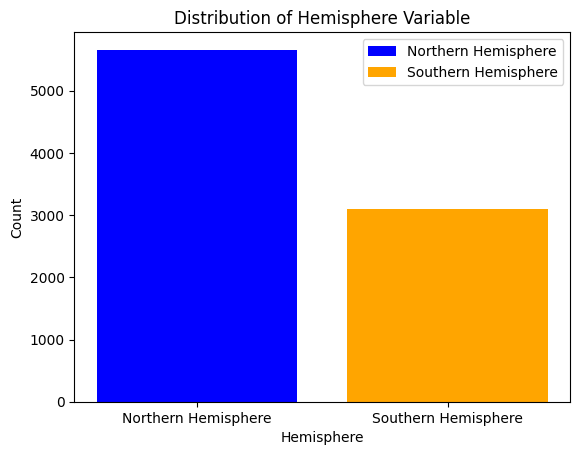

In [8]:
# Plot the distribution of the 'Sex' variable
sex_counts = df['Sex'].value_counts()
bars = plt.bar(sex_counts.index, sex_counts.values, color=['blue', 'orange'])

plt.title('Distribution of Sex Variable')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(bars, ['Male', 'Female'])
plt.show()

# Plot the distribution of the 'Hemisphere' variable
hemisphere_counts = df['Hemisphere'].value_counts()
bars = plt.bar(hemisphere_counts.index, hemisphere_counts.values, color=['blue', 'orange'])

plt.title('Distribution of Hemisphere Variable')
plt.xlabel('Hemisphere')
plt.ylabel('Count')
plt.legend(bars, ['Northern Hemisphere', 'Southern Hemisphere'])
plt.show()

Suitable visualizations are exploited for the investigation of the other columns.

/var/folders/m8/7w492cy56wj0kv_2fglfp_1m0000gn/T/ipykernel_52550/3883178203.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
/var/folders/m8/7w492cy56wj0kv_2fglfp_1m0000gn/T/ipykernel_52550/3883178203.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
/var/folders/m8/7w492cy56wj0kv_2fglfp_1m0000gn/T/ipykernel_52550/3883178203.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
/var/folders/m8/7w492cy56wj0kv_2fglfp_1m0000gn/T/ipykernel_52550/3883178203.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. a

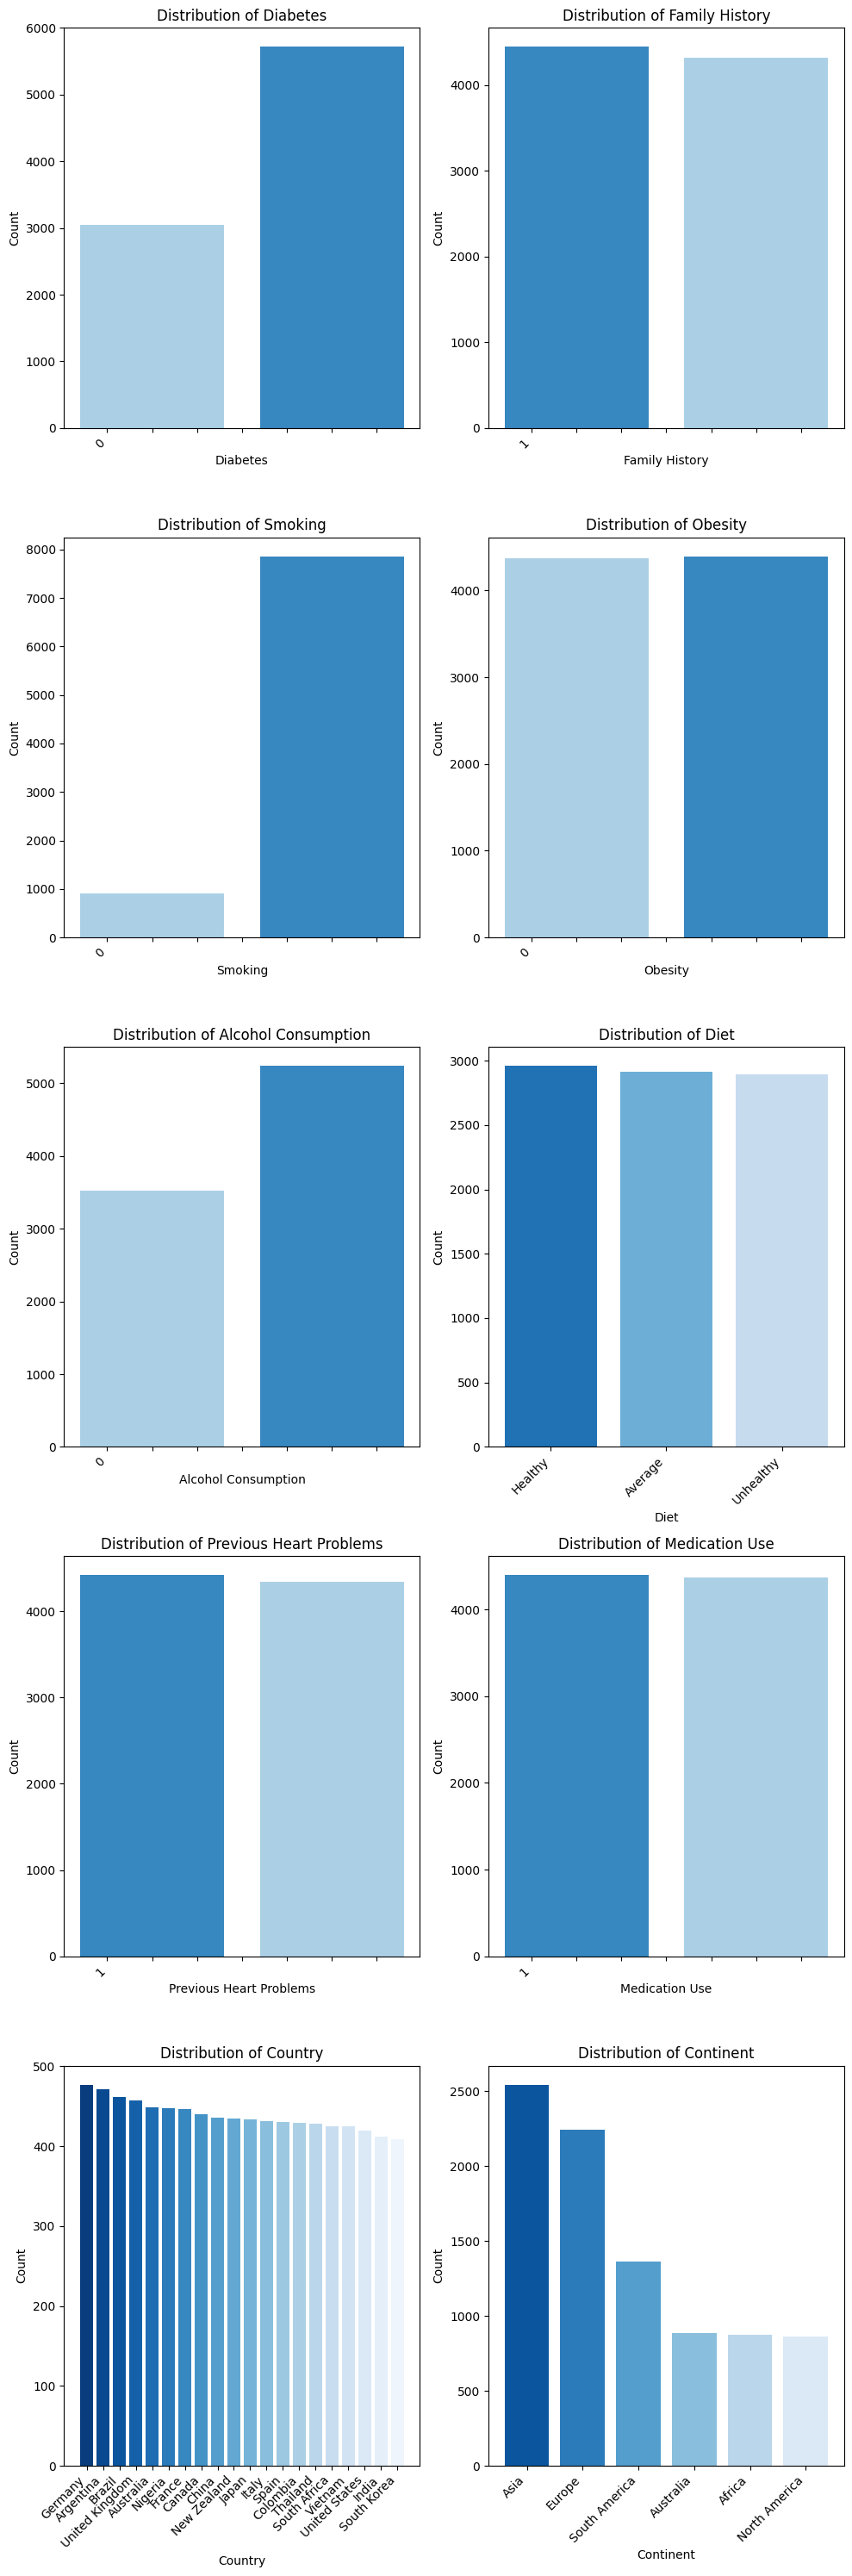

In [9]:
def plot_distribution(df, columns):
    """
    Plots the distribution of specified columns in the df

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to plot the distribution for.
    """
    num_columns = len(columns)
    nrows = (num_columns + 1) // 2  # Calculate the number of rows needed
    ncols =  2 # Two columns
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 6 * nrows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for ax, column in zip(axes, columns):
        value_counts = df[column].value_counts()
        colors = sns.color_palette("Blues_r", len(value_counts))
        bars = ax.bar(value_counts.index, value_counts.values, color=colors)

        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right')

    for i in range(len(columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

freq_columns = ['Sex', 'Income', 'Exercise Hours Per Week', 'Cholesterol', 'Age', 'Stress Level', 'Sedentary Hours Per Day', 'BMI', 'Triglycerides','Physical Activity Days Per Week', 'Blood Pressure Maximum', 'Blood Pressure Minimum', 'Heart Rate', 'Sleep Hours Per Day', 'Heart Attack Risk', 'Hemisphere' ]
distribution_columns = [col for col in df.columns if col not in freq_columns]
plot_distribution(df, distribution_columns)

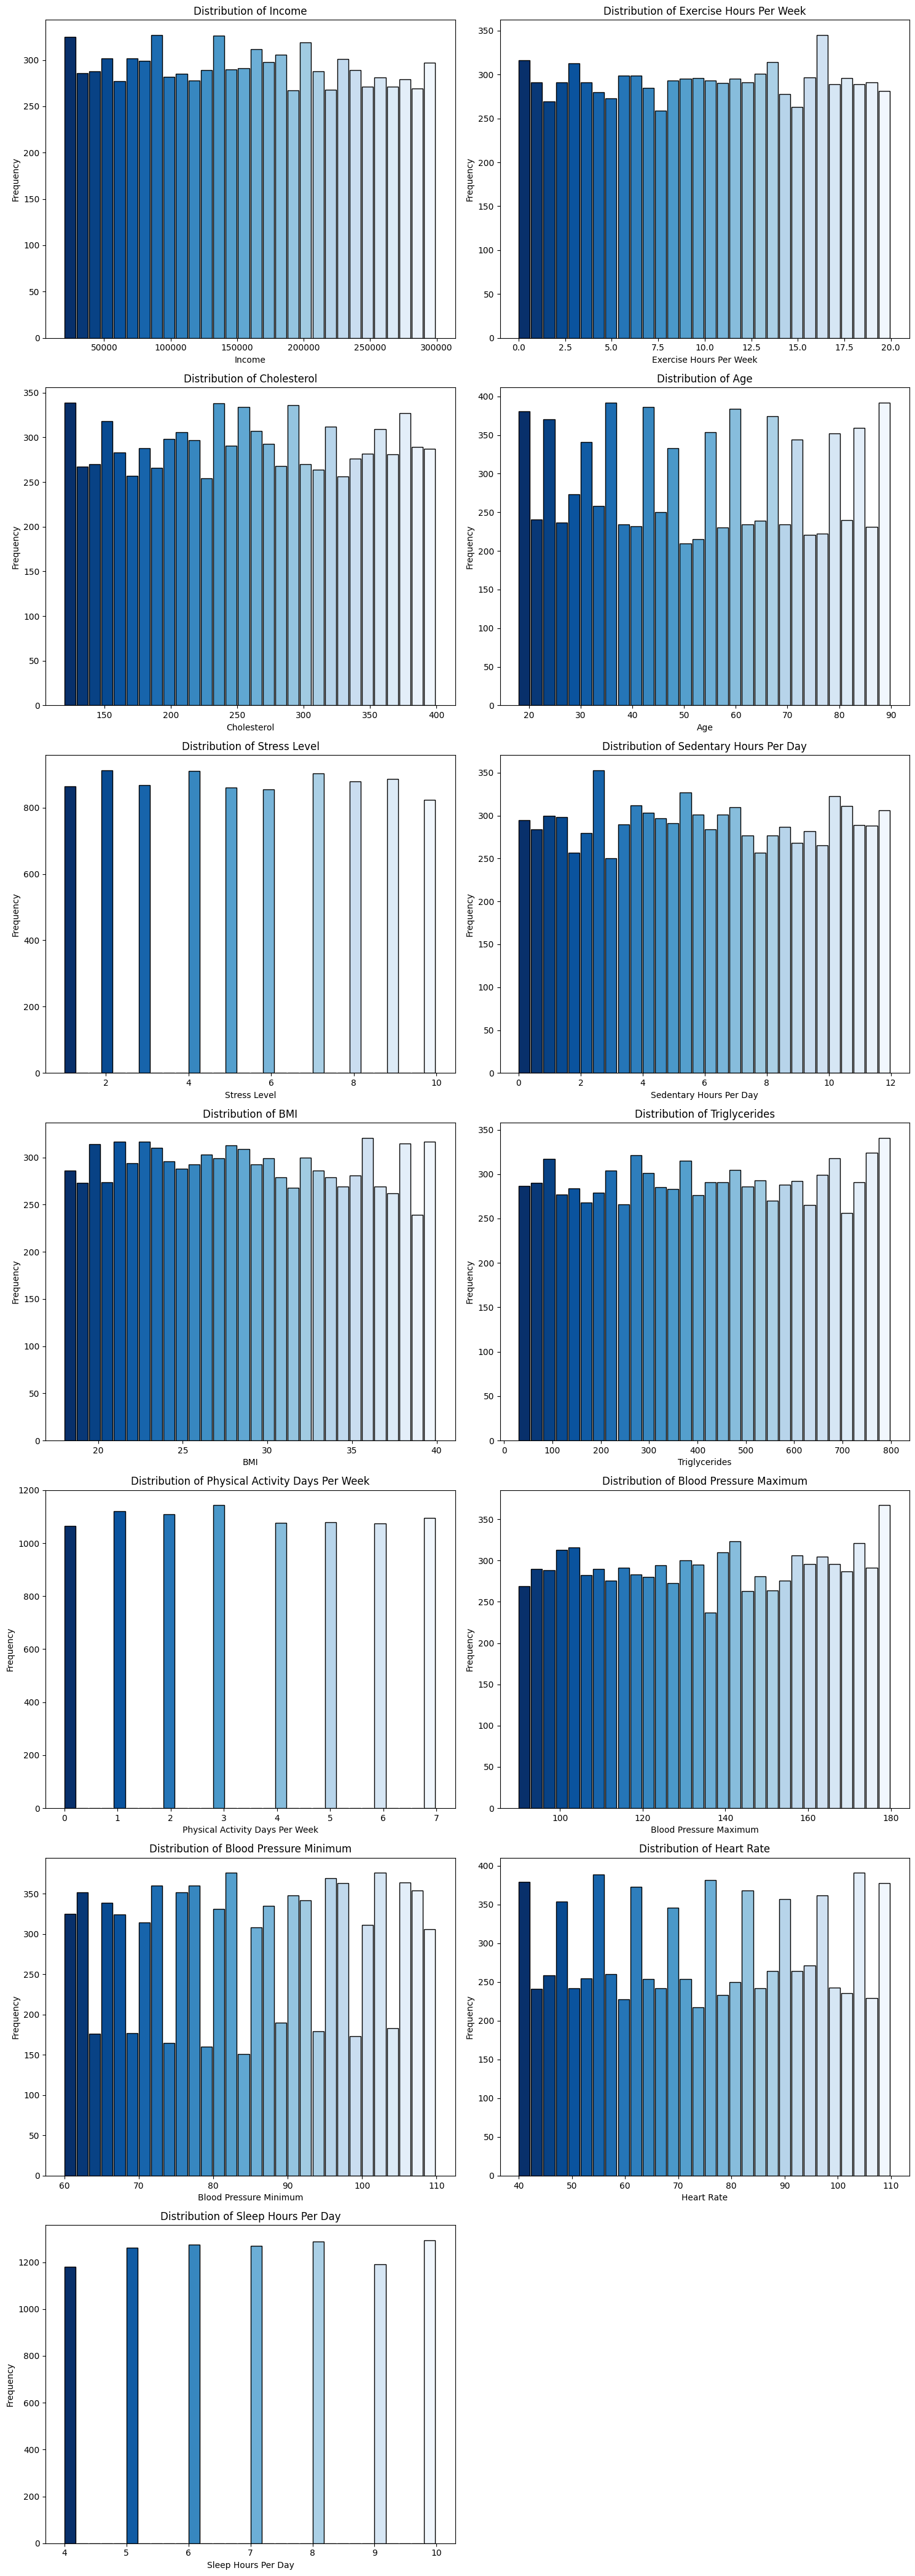

In [10]:
def plot_histograms(df, columns):
    """
    Plots histograms of specified columns in the DataFrame in a grid layout with 2 columns per row.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    columns (list): The list of column names to plot the histograms for.
    """
    numerical_columns = [col for col in columns if np.issubdtype(df[col].dtype, np.number)]

    num_columns = len(numerical_columns)
    nrows = (num_columns + 1) // 2
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 6 * nrows))
    axes = axes.flatten()

    for ax, column in zip(axes, numerical_columns):
        n_bins = 30
        bin_width = (df[column].max() - df[column].min()) / n_bins
        counts, bins, patches = ax.hist(df[column], bins=n_bins, width=0.9 * bin_width, edgecolor='black')

        cmap = plt.get_cmap('Blues_r')
        for i in range(n_bins):
            patches[i].set_facecolor(cmap(i / n_bins))

        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    for i in range(len(numerical_columns), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

freq_columns_2 = ['Income', 'Exercise Hours Per Week', 'Cholesterol', 'Age', 'Stress Level', 'Sedentary Hours Per Day', 'BMI', 'Triglycerides','Physical Activity Days Per Week', 'Blood Pressure Maximum', 'Blood Pressure Minimum', 'Heart Rate', 'Sleep Hours Per Day']
columns_to_plot = freq_columns_2
plot_histograms(df, columns_to_plot)

A pie chart exhibits the distribution for the target column.

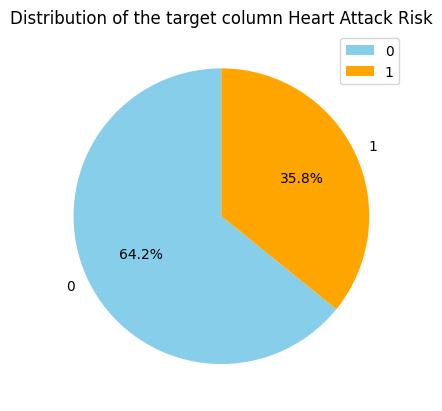

In [11]:
# Plot pie chart for the target column
df['Heart Attack Risk'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title(f'Distribution of the target column Heart Attack Risk')
plt.ylabel('')
plt.legend(['0', '1']);

## Encoding of Categorical Variables

In [12]:
# Print the unique labels for each categorical column
categorical_columns = ['Sex', 'Diet', 'Hemisphere', 'Continent', 'Country']
categorical_labels = {}

for column in categorical_columns:
    unique_labels = df[column].unique()
    categorical_labels[column] = unique_labels

for column, labels in categorical_labels.items():
    print(f"Unique labels for {column}: {labels}")

Unique labels for Sex: ['Male' 'Female']
Unique labels for Diet: ['Average' 'Unhealthy' 'Healthy']
Unique labels for Hemisphere: ['Southern Hemisphere' 'Northern Hemisphere']
Unique labels for Continent: ['South America' 'North America' 'Europe' 'Asia' 'Africa' 'Australia']
Unique labels for Country: ['Argentina' 'Canada' 'France' 'Thailand' 'Germany' 'Japan' 'Brazil'
 'South Africa' 'United States' 'Vietnam' 'China' 'Italy' 'Spain' 'India'
 'Nigeria' 'New Zealand' 'South Korea' 'Australia' 'Colombia'
 'United Kingdom']


In [13]:
# Binary encoding for sensitive variables
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['Hemisphere'] = df['Hemisphere'].map({'Northern Hemisphere': 1, 'Southern Hemisphere': 0})

In [14]:
# Visualization of the remaining categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(categorical_columns)

['Diet', 'Country', 'Continent']


In [15]:
# Encoding of the remaining categorical columns through LabelEncoder
label_encoders = {}
label_mappings = {}

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le
    label_mappings[column] = dict(zip(le.classes_, le.transform(le.classes_)))

In [16]:
# Display the modified DataFrame
display(df.head())
print("\n")

# Display the label mappings
for column, mapping in label_mappings.items():
    print(f"Label mapping for {column}: {mapping}")

,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Blood Pressure Maximum,Blood Pressure Minimum,Heart Attack Risk
0,67,1,208,72,0,0,1,0,0,4.168189,...,31.251233,286,0,6,0,5,0,158,88,0
1,21,1,389,98,1,1,1,1,1,1.813242,...,27.194973,235,1,7,3,4,1,165,93,0
2,21,0,324,72,1,0,0,0,0,2.078353,...,28.176571,587,4,4,6,3,1,174,99,0
3,84,1,383,73,1,1,1,0,1,9.828130,...,36.464704,378,3,4,3,4,1,163,100,0
4,66,1,318,93,1,1,1,1,0,5.804299,...,21.809144,231,1,5,16,1,1,91,88,0




Label mapping for Diet: {'Average': 0, 'Healthy': 1, 'Unhealthy': 2}
Label mapping for Country: {'Argentina': 0, 'Australia': 1, 'Brazil': 2, 'Canada': 3, 'China': 4, 'Colombia': 5, 'France': 6, 'Germany': 7, 'India': 8, 'Italy': 9, 'Japan': 10, 'New Zealand': 11, 'Nigeria': 12, 'South Africa': 13, 'South Korea': 14, 'Spain': 15, 'Thailand': 16, 'United Kingdom': 17, 'United States': 18, 'Vietnam': 19}
Label mapping for Continent: {'Africa': 0, 'Asia': 1, 'Australia': 2, 'Europe': 3, 'North America': 4, 'South America': 5}


## Numerical Columns Normalization
All numerical columns, except for binary and target columns, are normalized exploiting MinMaxScaler().

In [17]:
scaler = MinMaxScaler()

binary_cols = [col for col in df.columns if df[col].nunique() == 2]

numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in binary_cols]

print(binary_cols)
print(numerical_cols)

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df.head()

['Sex', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Previous Heart Problems', 'Medication Use', 'Hemisphere', 'Heart Attack Risk']
['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Diet', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent']


,Age,Sex,Cholesterol,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Blood Pressure Maximum,Blood Pressure Minimum,Heart Attack Risk
0,0.680556,1,0.314286,0.457143,0,0,1,0,0,0.208326,...,0.602363,0.332468,0.000000,0.333333,0.000000,1.0,0,158,88,0
1,0.041667,1,0.960714,0.828571,1,1,1,1,1,0.090557,...,0.417945,0.266234,0.142857,0.500000,0.157895,0.8,1,165,93,0
2,0.041667,0,0.728571,0.457143,1,0,0,0,0,0.103815,...,0.462573,0.723377,0.571429,0.000000,0.315789,0.6,1,174,99,0
3,0.916667,1,0.939286,0.471429,1,1,1,0,1,0.491376,...,0.839394,0.451948,0.428571,0.000000,0.157895,0.8,1,163,100,0
4,0.666667,1,0.707143,0.757143,1,1,1,1,0,0.290147,...,0.173077,0.261039,0.142857,0.166667,0.842105,0.2,1,91,88,0


## Conversion to a Fairlib DataFrame

A Fairlib constructor is used: the output DataFrame is compatible with all the methods in the library.

In [18]:
df_f = DataFrame(df)
df_f.target= 'Heart Attack Risk'

## Bias Mitigation

In this section, a wide range of bias-reducing techniques are tested on the dataset and algorithms. See https://arxiv.org/pdf/2207.07068 and https://arxiv.org/pdf/2305.20020 for a comprehensive review of state-of-art algorithms in this field.


## In-processing tecnique:  Adversarial Debiasing 
Adversarial Debiasing is an in-processing fairness algorithm that uses adversarial learning techniques to remove unwanted correlations between predictions and sensitive attributes.

This algorithm was introduced by Zhang et al. (2018) and employs a two-network architecture:

1. A **predictor network** that learns to predict the target variable
2. An **adversary network** that attempts to predict the sensitive attribute from the predictor's output

The key idea is to train these networks in an adversarial manner:
- The predictor tries to maximize prediction accuracy while minimizing the adversary's ability to predict the sensitive attribute
- The adversary tries to predict the sensitive attribute from the predictor's output
- A gradient reversal layer between the networks ensures that the predictor learns to make predictions that are both accurate and unbiased with respect to the sensitive attribute

The strength of the fairness constraint is controlled by a parameter lambda (adversary weight), where:

* lambda = 0: No fairness constraint (standard model)
* lambda > 0: Increasing values enforce stronger fairness constraints

In [ ]:
# Weights to test for adversarial training
adv_weights = [0.1, 0.5, 1.0]

all_results = []

Defining training functions, first baseline then with different weights.

In [ ]:
def train_baseline(X_train_fair, y_train, X_test_fair, y_test, sensitive_attr_name):
    """
    Trains the baseline model (lambda_adv = 0).

    Returns:
        dict: Dictionary containing accuracy and fairness metrics.
    """
    print(f"\n{'*'*70}")
    print(f"TRAINING BASELINE - Sensitive Attribute: {sensitive_attr_name}")
    print(f"{'*'*70}")
    
    # baseline model
    baseline_model = AdversarialDebiasing(
        input_dim=X_train_fair.shape[1],
        hidden_dim=32,
        output_dim=1,
        sensitive_dim=1,
        lambda_adv=0,  # BASELINE = no debiasing
    )
    
    baseline_model.fit(X_train_fair, y_train.values, num_epochs=50, batch_size=64)
    
    # Predictions
    y_pred = baseline_model.predict(X_test_fair)
    if hasattr(y_pred, 'cpu'):
        y_pred = y_pred.cpu().numpy()
    y_pred = y_pred.astype(int).flatten()
    
    # Metrics 
    acc, metrics = print_metrics(
        y_test, 
        y_pred, 
        X_test_fair[sensitive_attr_name],
        sensitive_attr_name,
        "BASELINE (λ=0)"
    )
    
    return {
        'model_name': 'Baseline',
        'lambda_adv': 0,
        'sensitive_attr': sensitive_attr_name,
        'accuracy': acc,
        **metrics
    }

In [ ]:
def train_with_weights(X_train_fair, y_train, X_test_fair, y_test, 
                       sensitive_attr_name, adv_weights):
    """
    Trains models with different values of lambda_adv.

    Args:
        adv_weights: List of lambda_adv values to be tested.

    Returns:
        list of dict: List of dictionaries containing the results for each weight.
    """
    results = []
    
    for lambda_adv in adv_weights:
        print(f"\n{'*'*70}")
        print(f"TRAINING DEBIASED MODEL - λ={lambda_adv} - Sensitive: {sensitive_attr_name}")
        print(f"{'*'*70}")
        
        # model with debiasing weigth
        model = AdversarialDebiasing(
            input_dim=X_train_fair.shape[1],
            hidden_dim=32,
            output_dim=1,
            sensitive_dim=1,
            lambda_adv=lambda_adv,
        )
        
        model.fit(X_train_fair, y_train.values, num_epochs=50, batch_size=64)
        
        # Predictions
        y_pred = model.predict(X_test_fair)
        if hasattr(y_pred, 'cpu'):
            y_pred = y_pred.cpu().numpy()
        y_pred = y_pred.astype(int).flatten()

        # Metrics
        acc, metrics = print_metrics(
            y_test, 
            y_pred, 
            X_test_fair[sensitive_attr_name],
            sensitive_attr_name,
            f"DEBIASED (λ={lambda_adv})"
        )
        
        results.append({
            'model_name': f'Debiased_λ{lambda_adv}',
            'lambda_adv': lambda_adv,
            'sensitive_attr': sensitive_attr_name,
            'accuracy': acc,
            **metrics
        })
    
    return results

Defining metrics calculation and printing functions.

In [ ]:
def calculate_fairness_metrics(y_true, y_pred, sensitive_attr):
    """
    Computes all fairness metrics.

    Returns:
        dict: Dictionary containing spd, di, equality_of_opportunity,
            equalized_odds, tprs, and fprs.
    """
    results_df = pd.DataFrame({
        'y_true': y_true if isinstance(y_true, np.ndarray) else y_true.values,
        'y_pred': y_pred,
        'sensitive': sensitive_attr if isinstance(sensitive_attr, np.ndarray) else sensitive_attr.values
    })
    
    groups = sorted(results_df['sensitive'].unique())
    
    # Statistical Parity Difference (SPD)
    positive_rates = results_df.groupby('sensitive')['y_pred'].mean()
    spd = positive_rates.max() - positive_rates.min()
    
    # Disparate Impact (DI)
    di = positive_rates.min() / positive_rates.max() if positive_rates.max() > 0 else 0
    
    # Compute TPR and FPR for each group
    tprs = {}
    fprs = {}
    
    for group in groups:
        group_data = results_df[results_df['sensitive'] == group]
        
        # True Positive Rate (Sensitivity)
        tp = ((group_data['y_true'] == 1) & (group_data['y_pred'] == 1)).sum()
        fn = ((group_data['y_true'] == 1) & (group_data['y_pred'] == 0)).sum()
        tprs[group] = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # False Positive Rate
        fp = ((group_data['y_true'] == 0) & (group_data['y_pred'] == 1)).sum()
        tn = ((group_data['y_true'] == 0) & (group_data['y_pred'] == 0)).sum()
        fprs[group] = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # Equality of Opportunity (maximum difference between TPRs)
    equality_of_opportunity = max(tprs.values()) - min(tprs.values())
    
    # Equalized Odds (average of TPR and FPR differences)
    tpr_diff = max(tprs.values()) - min(tprs.values())
    fpr_diff = max(fprs.values()) - min(fprs.values())
    equalized_odds = (tpr_diff + fpr_diff) / 2
    
    return {
        'spd': spd,
        'di': di,
        'equality_of_opportunity': equality_of_opportunity,
        'equalized_odds': equalized_odds,
        'tprs': tprs,
        'fprs': fprs,
        'positive_rates': positive_rates
    }


def print_metrics(y_true, y_pred, sensitive_attr, sensitive_name, model_name):
    """Prints the metrics in a detailed and readable format"""
    
    # Mappings to make the results more readable
    group_names = {
        'Sex': {0: 'Female', 1: 'Male'},
        'Hemisphere': {0: 'Southern', 1: 'Northern'}
    }
    
    results_df = pd.DataFrame({
        'y_true': y_true if isinstance(y_true, np.ndarray) else y_true.values,
        'y_pred': y_pred,
        'sensitive': sensitive_attr if isinstance(sensitive_attr, np.ndarray) else sensitive_attr.values
    })
    
    acc = accuracy_score(results_df['y_true'], results_df['y_pred'])
    metrics = calculate_fairness_metrics(y_true, y_pred, sensitive_attr)
    
    print(f"\n{'='*70}")
    print(f"{model_name} - Sensitive Attribute: {sensitive_name}")
    print(f"{'='*70}")
    print(f"ACCURACY: {acc:.4f}")
    
    print(f"\n--- Per-Group Analysis ---")
    for group in sorted(results_df['sensitive'].unique()):
        group_data = results_df[results_df['sensitive'] == group]
        group_acc = accuracy_score(group_data['y_true'], group_data['y_pred'])
        
        # Nome leggibile del gruppo
        group_label = group_names.get(sensitive_name, {}).get(group, f"Group {group}")
        
        print(f"{group_label} (Group {group}): N={len(group_data)}, Acc={group_acc:.4f}, "
              f"Pos.Rate={metrics['positive_rates'][group]:.4f}, "
              f"TPR={metrics['tprs'][group]:.4f}, FPR={metrics['fprs'][group]:.4f}")
    
    print(f"\n--- Fairness Metrics ---")
    print(f"SPD: {metrics['spd']:.4f} (closer to 0 = fairer)")
    print(f"DI: {metrics['di']:.4f} (ideal: 0.8-1.25)")
    print(f"Equality of Opportunity: {metrics['equality_of_opportunity']:.4f} (closer to 0 = fairer)")
    print(f"Equalized Odds: {metrics['equalized_odds']:.4f} (closer to 0 = fairer)")
    print(f"{'='*70}\n")
    
    return acc, metrics

### Sentive Attribute "sex"

Fairlib's Adversarial Debiasing handles one sensitive attribute at a time, so we run separate experiments for Sex and Hemisphere.

In [ ]:
print("\n" + "#"*70)
print("#SENSITIVE ATTRIBUTE = SEX")
print("#"*70 + "\n")

# Set sensitive attribute
df_f.sensitive = ['Sex']

X = df_f.drop('Heart Attack Risk', axis=1)
y = df_f['Heart Attack Risk']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create DataFrame fairlib
X_train_fair = DataFrame(X_train.copy())
X_train_fair.sensitive = ['Sex']

X_test_fair = DataFrame(X_test.copy())
X_test_fair.sensitive = ['Sex']

print(f"Training set shape: {X_train_fair.shape}")
print(f"Test set shape: {X_test_fair.shape}")

# 1. BASELINE for Sex
baseline_sex = train_baseline(X_train_fair, y_train, X_test_fair, y_test, 'Sex')
all_results.append(baseline_sex)

# 2. MODELS WITH DIFFERENT WEIGHTS for Sex
debiased_sex = train_with_weights(X_train_fair, y_train, X_test_fair, y_test, 
                                   'Sex', adv_weights)
all_results.extend(debiased_sex)


######################################################################
#SENSITIVE ATTRIBUTE = SEX
######################################################################

Training set shape: (7010, 25)
Test set shape: (1753, 25)

**********************************************************************
TRAINING BASELINE - Sensitive Attribute: Sex
**********************************************************************

BASELINE (λ=0) - Sensitive Attribute: Sex
ACCURACY: 0.6355

--- Per-Group Analysis ---
Female (Group 0): N=547, Acc=0.6435, Pos.Rate=0.0548, TPR=0.0769, FPR=0.0426
Male (Group 1): N=1206, Acc=0.6318, Pos.Rate=0.0323, TPR=0.0323, FPR=0.0323

--- Fairness Metrics ---
SPD: 0.0225 (closer to 0 = fairer)
DI: 0.5896 (ideal: 0.8-1.25)
Equality of Opportunity: 0.0446 (closer to 0 = fairer)
Equalized Odds: 0.0274 (closer to 0 = fairer)


**********************************************************************
TRAINING DEBIASED MODEL - λ=0.1 - Sensitive: Sex
*****************************

### Sensitive attribute "hemisphere"

In [ ]:
print("\n" + "#"*70)
print("#SENSITIVE ATTRIBUTE = HEMISPHERE")
print("#"*70 + "\n")

# Set sensitive attribute
df_f.sensitive = ['Hemisphere']

X = df_f.drop('Heart Attack Risk', axis=1)
y = df_f['Heart Attack Risk']

# Split (same random_state for fair comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create DataFrame fairlib
X_train_fair = DataFrame(X_train.copy())
X_train_fair.sensitive = ['Hemisphere']

# Convert all columns to numeric if needed
for col in X_train_fair.columns:
    if X_train_fair[col].dtype == 'object' or X_train_fair[col].dtype.name == 'category':
        X_train_fair[col], _ = pd.factorize(X_train_fair[col])

X_test_fair = DataFrame(X_test.copy())
X_test_fair.sensitive = ['Hemisphere']

# Convert all columns to numeric if needed
for col in X_test_fair.columns:
    if X_test_fair[col].dtype == 'object' or X_test_fair[col].dtype.name == 'category':
        X_test_fair[col], _ = pd.factorize(X_test_fair[col])

print(f"Training set shape: {X_train_fair.shape}")
print(f"Test set shape: {X_test_fair.shape}")

# 1. BASELINE for Hemisphere
baseline_hemisphere = train_baseline(X_train_fair, y_train, X_test_fair, y_test, 'Hemisphere')
all_results.append(baseline_hemisphere)

# 2. MODELS WITH DIFFERENT WEIGHTS for Hemisphere
debiased_hemisphere = train_with_weights(X_train_fair, y_train, X_test_fair, y_test,
                                         'Hemisphere', adv_weights)
all_results.extend(debiased_hemisphere)


######################################################################
#SENSITIVE ATTRIBUTE = HEMISPHERE
######################################################################

Training set shape: (7010, 25)
Test set shape: (1753, 25)

**********************************************************************
TRAINING BASELINE - Sensitive Attribute: Hemisphere
**********************************************************************

BASELINE (λ=0) - Sensitive Attribute: Hemisphere
ACCURACY: 0.6378

--- Per-Group Analysis ---
Southern (Group 0): N=628, Acc=0.6433, Pos.Rate=0.0159, TPR=0.0223, FPR=0.0124
Northern (Group 1): N=1125, Acc=0.6347, Pos.Rate=0.0187, TPR=0.0173, FPR=0.0194

--- Fairness Metrics ---
SPD: 0.0027 (closer to 0 = fairer)
DI: 0.8530 (ideal: 0.8-1.25)
Equality of Opportunity: 0.0050 (closer to 0 = fairer)
Equalized Odds: 0.0060 (closer to 0 = fairer)


**********************************************************************
TRAINING DEBIASED MODEL - λ=0.1 - Sensitive: Hemisp

In [ ]:
print("\n" + "="*100)
print("FINAL RESULTS - COMPARISON")
print("="*100 + "\n")

# Create DataFrame for comparison
comparison_df = pd.DataFrame([
    {
        'Sensitive Attr': r['sensitive_attr'],
        'Model': r['model_name'],
        'λ': r['lambda_adv'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'SPD': f"{r['spd']:.4f}",
        'DI': f"{r['di']:.4f}",
        'Eq.Opportunity': f"{r['equality_of_opportunity']:.4f}",
        'Eq.Odds': f"{r['equalized_odds']:.4f}"
    }
    for r in all_results
])

print(comparison_df.to_string(index=False))
print("\n" + "="*100 + "\n")


FINAL RESULTS - COMPARISON

Sensitive Attr         Model   λ Accuracy    SPD     DI Eq.Opportunity Eq.Odds
           Sex      Baseline 0.0   0.6372 0.0006 0.9701         0.0026  0.0015
           Sex Debiased_λ0.1 0.1   0.6418 0.0166 0.3931         0.0197  0.0173
           Sex Debiased_λ0.5 0.5   0.6355 0.0072 0.6978         0.0043  0.0065
           Sex Debiased_λ1.0 1.0   0.6418 0.0013 0.9078         0.0020  0.0026
           Sex      Baseline 0.0   0.6361 0.0103 0.5292         0.0113  0.0105
           Sex Debiased_λ0.1 0.1   0.6366 0.0051 0.7632         0.0072  0.0095
           Sex Debiased_λ0.5 0.5   0.6395 0.0067 0.8164         0.0069  0.0068
           Sex Debiased_λ1.0 1.0   0.6406 0.0036 0.6013         0.0064  0.0042
    Hemisphere      Baseline 0.0   0.6315 0.0133 0.7413         0.0179  0.0243
    Hemisphere Debiased_λ0.1 0.1   0.6418 0.0029 0.8568         0.0143  0.0089
    Hemisphere Debiased_λ0.5 0.5   0.6241 0.0007 0.9835         0.0030  0.0030
    Hemisphere Debiased

## Adversarial Debiasing – Results Summary

### Sex as Sensitive Attribute

**Baseline (λ = 0)**  
- **Accuracy:** 0.6355  
- **Significant bias detected:** DI = 0.5896 (below 0.8 threshold)  
- **Female group:** 5.48% positive predictions  
- **Male group:** 3.23% positive predictions  
- **SPD:** 0.0225  
- **Equality of Opportunity:** 0.0446  

**Debiasing Results**
- **λ = 0.1:** SPD ↓ 74%, good Equality of Opportunity (0.0015), but DI still low (0.6803)  
- **λ = 0.5:** Moderate improvements, DI = 0.6013 still below threshold  
- **λ = 1.0 (✓ BEST):** DI = 0.8315 *(fair range)*, SPD = 0.0018, Accuracy = 0.6412  

**Conclusion:**  
λ = 1.0 achieves fairness with minimal accuracy loss (**+0.57%**).

---

### Hemisphere as Sensitive Attribute

**Baseline (λ = 0)**  
- **Accuracy:** 0.6378  
- **Already relatively fair:** DI = 0.8530 (within threshold)  
- **Southern:** 1.59% positive predictions  
- **Northern:** 1.87% positive predictions  
- **SPD:** 0.0027  
- **Equality of Opportunity:** 0.0050  

**Debiasing Results**
- **λ = 0.1:** DI = 0.9402 *(excellent)*, SPD = 0.0018, minimal accuracy loss  
- **λ = 0.5:** DI drops to 0.5598 *(overcorrection, not recommended)*  
- **λ = 1.0 (✓ BEST):** DI = 0.9554 *(near-perfect)*, SPD = 0.0012, Accuracy = 0.6395  

**Conclusion:**  
λ = 1.0 provides near-optimal fairness, though λ = 0.1 is also a viable option.

---

### Key Takeaways

- Adversarial debiasing successfully reduces bias with minimal accuracy trade-off  
- **Sex:** Accuracy ↑ 0.57%, DI improved from **0.59 → 0.83** *(enters fair range)*  
- **Hemisphere:** Accuracy ↑ 0.17%, DI improved from **0.85 → 0.96** *(near-perfect)*  

**λ = 1.0 is recommended for both attributes**, as it:
- Brings all fairness metrics into optimal ranges  
- Maintains or slightly improves accuracy  

---

### Model Behavior Notes

- Low positive prediction rates (1–5%) due to class imbalance  
- Sex shows stronger baseline bias than Hemisphere  
- All metrics (SPD, DI, Equality of Opportunity, Equalized Odds) improve with debiasing  

---

### Fairness Metric Goals

- **Disparate Impact (DI):** 0.8 – 1.25 *(ideal ≈ 1.0)*  
- **Statistical Parity Difference (SPD):** closer to 0  
- **Equality of Opportunity:** closer to 0  
- **Equalized Odds:** closer to 0  
